In [3]:
import pandas as pd
import numpy as np
import time
import math
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchinfo import summary

import evaluate

from io import open
import unicodedata
import string
import re
import random
import os
import os.path as osp

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


# Config

In [51]:
# I/O
STAGE                   = 'debug'
unk_token               = "[UNK]"
pad_token               = "[PAD]"
sos_token               = "[SOS]"
eos_token               = "[EOS]"
SPECIAL_TOKENS          = [
                            pad_token,
                            sos_token,
                            eos_token,
                            unk_token
                        ]
HF_USERNAME             = "dric2018"
HF_REPO_NAME            = "dyu-fr-mt"
PROJECT_PATH            = '/content/drive/MyDrive/R_D/competitions/zindi_fr_dyula_mt'
MODEL_ZOO               = osp.join(PROJECT_PATH, "models")
DATA_DIR                = osp.join(PROJECT_PATH, "data")

# Model
MAX_LENGTH              = 128
teacher_forcing_ratio   = 0.5
BATCH_SIZE              = 32
LR                      = 1e-3
EPOCHS                  = 25 if STAGE == 'debug' else 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Seeding

In [5]:
seed = 2024

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if device =="cuda":
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Data Pre-processing

## Load Dataset

### HF Way

In [ ]:
# # Download data
# dataset = load_dataset(HF_DATASET_NAME)
# dataset

Generating train split:   0%|          | 0/8065 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1471 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1393 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'translation'],
        num_rows: 8065
    })
    validation: Dataset({
        features: ['ID', 'translation'],
        num_rows: 1471
    })
    test: Dataset({
        features: ['ID', 'translation'],
        num_rows: 1393
    })
})

In [ ]:
# dataset.column_names

{'train': ['ID', 'translation'],
 'validation': ['ID', 'translation'],
 'test': ['ID', 'translation']}

In [ ]:
# dataset["train"]

Dataset({
    features: ['ID', 'translation'],
    num_rows: 8065
})

In [ ]:
# dataset["validation"]

Dataset({
    features: ['ID', 'translation'],
    num_rows: 1471
})

### Pandas Way

#### Preprocess data

In [ ]:
# train_df = pd.read_parquet(osp.join(DATA_DIR, "train-00000-of-00001.parquet"))
# valid_df = pd.read_parquet(osp.join(DATA_DIR, "validation-00000-of-00001.parquet"))
# test_df = pd.read_parquet(osp.join(DATA_DIR, "test-00000-of-00001.parquet"))

# train_df.shape, valid_df.shape, test_df.shape

((8065, 2), (1471, 2), (1393, 2))

In [ ]:
# train_df.head()

,ID,translation
0,ID_18897661270129,"{'dyu': 'A bi ji min na', 'fr': 'Il boit de l’..."
1,ID_18479132727846,"{'dyu': 'A le dalakolontɛ lon bɛ.', 'fr': 'Il ..."
2,ID_18164131280307,"{'dyu': 'Mun? Fɛn dɔ.', 'fr': 'Quoi ? Quelque ..."
3,ID_18344573728152,"{'dyu': 'O bɛ bi bɔra fo Gubeta.', 'fr': 'Tous..."
4,ID_18127342282717,"{'dyu': 'A ale lo bi da bugɔ la!', 'fr': 'Ah !..."


In [ ]:
# test_df.head()

,ID,translation
0,ID_17345911362699,"{'dyu': 'An kelen duron le tun be yi', 'fr': '0'}"
1,ID_173626847.3381,"{'dyu': 'O ka papiye farana.', 'fr': '0'}"
2,ID_17704632382547,"{'dyu': 'N tɔrɔla kɔ tuguni', 'fr': '0'}"
3,ID_19793499384156,"{'dyu': 'I tun b'a daminɛ tan kɛ.', 'fr': '0'}"
4,ID_17802727385575,"{'dyu': 'A kɛra ka ban.', 'fr': '0'}"


In [ ]:
# def prepare_data(df):
#     df['dyu'] = df['translation'].apply(lambda x: x.get('dyu'))
#     df['fr']  = df['translation'].apply(lambda x: x.get('fr'))

#     # Drop the original column if it's no longer needed
#     df = df.drop(columns=['translation'])

#     # compute sequence lengths
#     df['dyu_len'] = df['dyu'].apply(lambda x: len(x))
#     df['fr_len']  = df['fr'].apply(lambda x: len(x))

#     return df.copy()

In [ ]:
# train = prepare_data(df=train_df)
# valid = prepare_data(df=valid_df)
# test = prepare_data(df=test_df)


In [ ]:
# train.head()

,ID,dyu,fr,dyu_len,fr_len
0,ID_18897661270129,A bi ji min na,Il boit de l’eau.,14,17
1,ID_18479132727846,A le dalakolontɛ lon bɛ.,Il se plaint toujours.,24,22
2,ID_18164131280307,Mun? Fɛn dɔ.,Quoi ? Quelque chose.,12,21
3,ID_18344573728152,O bɛ bi bɔra fo Gubeta.,Tous sortent excepté Gubetta.,23,29
4,ID_18127342282717,A ale lo bi da bugɔ la!,Ah ! c’est lui… il sonne…,23,25


In [ ]:
# valid.head()

,ID,dyu,fr,dyu_len,fr_len
0,ID_17914990255818,I tɔgɔ bi cogodɔ,Tu portes un nom de fantaisie.,16,30
1,ID_18135961264225,Puɛn saba fɔlɔ.,Trois points d’avance.,15,22
2,ID_18161475265686,Tile bena,Le soleil s’est couché.,9,23
3,ID_17305345266745,cogoya kelen,Mêmes mouvements.,12,17
4,ID_18106593267767,N ma daraka dun ban.,Je n’ai pas encore déjeuné.,20,27


In [ ]:
# test.head()

,ID,dyu,fr,dyu_len,fr_len
0,ID_17345911362699,An kelen duron le tun be yi,0,27,1
1,ID_173626847.3381,O ka papiye farana.,0,19,1
2,ID_17704632382547,N tɔrɔla kɔ tuguni,0,18,1
3,ID_19793499384156,I tun b'a daminɛ tan kɛ.,0,24,1
4,ID_17802727385575,A kɛra ka ban.,0,14,1


In [ ]:
# train.shape, valid.shape, test.shape

((8065, 5), (1471, 5), (1393, 5))

In [ ]:
# train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dyu_len,8065.0,25.568258,13.911661,2.0,17.0,22.0,30.0,123.0
fr_len,8065.0,32.481587,18.165819,4.0,22.0,26.0,32.0,121.0


In [ ]:
# valid.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dyu_len,1471.0,26.517335,14.514204,6.0,17.0,23.0,31.0,119.0
fr_len,1471.0,33.571720,18.691884,9.0,22.0,27.0,37.0,101.0


In [ ]:
# test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dyu_len,1393.0,26.221106,14.290146,3.0,17.0,23.0,30.0,148.0
fr_len,1393.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


#### Save data

In [ ]:
# train.to_csv(osp.join(DATA_DIR, "preprocessed/train.csv"), index=False)
# valid.to_csv(osp.join(DATA_DIR, "preprocessed/valid.csv"), index=False)
# test.to_csv(osp.join(DATA_DIR, "preprocessed/test.csv"), index=False)

## Load Preprocessed data

In [6]:
train = pd.read_csv(osp.join(DATA_DIR, "preprocessed/train.csv"))
valid = pd.read_csv(osp.join(DATA_DIR, "preprocessed/valid.csv"))
test = pd.read_csv(osp.join(DATA_DIR, "preprocessed/test.csv"))

In [7]:
train.shape, test.shape, valid.shape

((8065, 5), (1393, 5), (1471, 5))

In [8]:
train.sample(n=2)

,ID,dyu,fr,dyu_len,fr_len
5319,ID_17711556096575,Ɲan le n kɔrɔta nin lo.,C’est là que j’ai été élevé…,23,28
6345,ID_17639538728134,Ibidi livru den naani.,"quatre Ibid., liv.",22,18


In [9]:
valid.sample(n=2)

,ID,dyu,fr,dyu_len,fr_len
1318,ID_18095719521775,Nice ka sira gwangwan,Rue Poussière à Nicey,21,21
426,ID_18910610811824,alfrɛd mɔt ka sira urubait la,Avenue Alfred Motte à Roubaix,29,29


In [10]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dyu_len,8065.0,25.568258,13.911661,2.0,17.0,22.0,30.0,123.0
fr_len,8065.0,32.481587,18.165819,4.0,22.0,26.0,32.0,121.0


In [11]:
train[train["dyu_len"] <64].shape

(7842, 5)

## Text Parser

In [12]:
# Lowercase, trim, and remove non-letter characters
# def parseText(s):
#     s = re.sub(r"[!'&\(\),-./:;=?+.\n\[\]]", r" ", s.lower())
#     return s.strip()

def parseText(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove punctuation
    sentence = re.sub(f"[{re.escape(string.punctuation)}]", "", sentence)

    return sentence.strip()

## TorchText Tokenizer

In [13]:
class Tokenizer:
    def __init__(
            self,
            level:str="word"
        ):
        self.level = level

    def encode(self, text):
        text = parseText(text)

        if self.level =="word":
            return text.split()  # For word-level tokenization
        else:
            return list(text)  # For character-level tokenization

    def yield_tokens(self, data_iter):
        for text in data_iter:
            yield self.encode(text)

In [14]:
tokenizer = Tokenizer(level="word")

## Build Vocabularies

In [15]:
from torchtext.vocab import build_vocab_from_iterator

In [16]:
source_sentences = train.dyu.values.tolist() + valid.dyu.values.tolist()
target_sentences = train.fr.values.tolist() + valid.fr.values.tolist()

In [17]:
tokenizer.encode(source_sentences[0])

['a', 'bi', 'ji', 'min', 'na']

In [18]:
source_vocab = build_vocab_from_iterator(
    tokenizer.yield_tokens(source_sentences),
    min_freq = 2,
    specials=SPECIAL_TOKENS
)
source_vocab.set_default_index(source_vocab["[UNK]"])

target_vocab = build_vocab_from_iterator(
    tokenizer.yield_tokens(target_sentences),
    min_freq = 2,
    specials=SPECIAL_TOKENS
)
target_vocab.set_default_index(target_vocab["[UNK]"])

In [19]:
assert source_vocab[unk_token] == target_vocab[unk_token]
assert source_vocab[pad_token] == target_vocab[pad_token]

unk_index = source_vocab[unk_token]
pad_index = source_vocab[pad_token]

## Sentence Trimmer

In [20]:
def filter_samples(df, filter_col:str="dyu_len"):
    return df[df[filter_col] < MAX_LENGTH].copy()

## Prepare datasets

In [21]:
train_ = filter_samples(train, filter_col="dyu_len")
valid_ = filter_samples(valid, filter_col="dyu_len")

train_.shape, valid_.shape

((8065, 5), (1471, 5))

In [22]:
train_.sample(n=1)

,ID,dyu,fr,dyu_len,fr_len
770,ID_18582965898881,A tɔ tora sanu kuruwo.,Il la vit par le carreau.,22,25


In [23]:
valid_.sample(n=1)

,ID,dyu,fr,dyu_len,fr_len
283,ID_18075010605924,"anh! Hɔn, dɔnkililabaga lo!","Oh ! oui, il est artiste !",27,26


## Create PyTorch Dataset and Data loader

In [52]:
class DyulaDataset(Dataset):
    def __init__(
        self,
        df,
        source_vocab,
        target_vocab,
        tokenizer
    ):
        self.df = df
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        source_sentence = self.df.iloc[idx].dyu
        target_sentence = self.df.iloc[idx].fr

        source_tokens = [self.source_vocab[token] for token in self.tokenizer.encode(source_sentence)]
        target_tokens = [self.target_vocab[token] for token in self.tokenizer.encode(target_sentence)]

        source_tokens = [self.source_vocab["[SOS]"]] + source_tokens + [self.source_vocab["[EOS]"]]
        target_tokens = [self.target_vocab["[SOS]"]] + target_tokens + [self.target_vocab["[EOS]"]]

        return torch.tensor(source_tokens, dtype=torch.long), torch.tensor(target_tokens, dtype=torch.long)


# Collate function for padding
def collate_fn(batch):
    source_batch, target_batch = zip(*batch)
    source_batch = pad_sequence(source_batch, padding_value=source_vocab["[PAD]"])
    target_batch = pad_sequence(target_batch, padding_value=target_vocab["[PAD]"])
    return source_batch, target_batch


### Dataset

In [53]:
# Create dataset
train_dataset = DyulaDataset(
    df=train_,
    source_vocab=source_vocab,
    target_vocab=target_vocab,
    tokenizer=tokenizer
)

valid_dataset = DyulaDataset(
    df=valid_,
    source_vocab=source_vocab,
    target_vocab=target_vocab,
    tokenizer=tokenizer
)

In [54]:
src, tgt = train_dataset[0]

src, tgt

(tensor([  1,   4,   6, 169,  25,   9,   2]),
 tensor([   1,    7, 1621,    4,  430,    2]))

### Dataloader

In [55]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [56]:
# Example usage
for source_batch, target_batch in train_dataloader:
    print("Source batch:", source_batch.shape)
    print("Target batch:", target_batch.shape)
    break

Source batch: torch.Size([17, 32])
Target batch: torch.Size([15, 32])


In [57]:
# Example usage
for source_batch, target_batch in valid_dataloader:
    print("Source batch:", source_batch.shape)
    print("Target batch:", target_batch.shape)
    break

Source batch: torch.Size([14, 32])
Target batch: torch.Size([8, 32])


# Modeling

## Encoder

In [58]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim:int=len(source_vocab),
        embedding_dim:int=256,
        encoder_hidden_dim:int=256,
        decoder_hidden_dim:int=256,
        dropout:float=0.5
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))
        return outputs, hidden

In [59]:
encoder = Encoder()
print(encoder)
summary(encoder)

Encoder(
  (embedding): Embedding(2543, 256)
  (rnn): GRU(256, 256, bidirectional=True)
  (fc): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Layer (type:depth-idx)                   Param #
Encoder                                  --
├─Embedding: 1-1                         651,008
├─GRU: 1-2                               789,504
├─Linear: 1-3                            131,328
├─Dropout: 1-4                           --
Total params: 1,571,840
Trainable params: 1,571,840
Non-trainable params: 0

## Attention

In [60]:
class Attention(nn.Module):
    def __init__(
        self,
        encoder_hidden_dim:int=256,
        decoder_hidden_dim:int=256
    ):

        super(Attention, self).__init__()
        self.attn   = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim)
        self.v_fc   = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)

        return torch.softmax(attention, dim=1)

In [61]:
attn = Attention()
print(attn)
summary(attn)

Attention(
  (attn): Linear(in_features=768, out_features=256, bias=True)
  (v_fc): Linear(in_features=256, out_features=1, bias=False)
)


Layer (type:depth-idx)                   Param #
Attention                                --
├─Linear: 1-1                            196,864
├─Linear: 1-2                            256
Total params: 197,120
Trainable params: 197,120
Non-trainable params: 0

## Decoder

In [62]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim:int=len(target_vocab),
        embedding_dim:int=256,
        encoder_hidden_dim:int=256,
        decoder_hidden_dim:int=256,
        dropout:float=0.5,
        num_layers:int=1
    ):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = Attention(encoder_hidden_dim, decoder_hidden_dim)
        self.rnn = nn.GRU(embedding_dim + encoder_hidden_dim * 2, decoder_hidden_dim, num_layers)
        self.fc_out = nn.Linear(embedding_dim + decoder_hidden_dim + encoder_hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        # compute attention weights
        attn_weights = self.attention(hidden, encoder_outputs)

        attn_weights = attn_weights.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        context = torch.bmm(attn_weights, encoder_outputs).squeeze(1)
        rnn_input = torch.cat((embedded, context.unsqueeze(0)), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = output.squeeze(0)
        output = self.fc_out(torch.cat((output, context, embedded.squeeze(0)), dim=1))

        return output, hidden.squeeze(0), attn_weights

In [63]:
decoder = Decoder()
print(decoder)
summary(decoder)

Decoder(
  (embedding): Embedding(4005, 256)
  (attention): Attention(
    (attn): Linear(in_features=768, out_features=256, bias=True)
    (v_fc): Linear(in_features=256, out_features=1, bias=False)
  )
  (rnn): GRU(768, 256)
  (fc_out): Linear(in_features=1024, out_features=4005, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Layer (type:depth-idx)                   Param #
Decoder                                  --
├─Embedding: 1-1                         1,025,280
├─Attention: 1-2                         --
│    └─Linear: 2-1                       196,864
│    └─Linear: 2-2                       256
├─GRU: 1-3                               787,968
├─Linear: 1-4                            4,105,125
├─Dropout: 1-5                           --
Total params: 6,115,493
Trainable params: 6,115,493
Non-trainable params: 0

## MT Model

In [90]:
class DyulaTranslator(nn.Module):
    def __init__(
            self,
            device,
            input_dim               :int    = len(source_vocab),
            output_dim              :int    = len(target_vocab),
            encoder_embedding_dim   :int    = 256,
            decoder_embedding_dim   :int    = 256,
            encoder_hidden_dim      :int    = 256,
            decoder_hidden_dim      :int    = 256,
            n_decoder_layers        :int    = 1,
            encoder_dropout         :float  = 0.5,
            decoder_dropout         :float  = 0.5
        ):
        super().__init__()
        self.encoder = Encoder(
            input_dim           = input_dim,
            embedding_dim       = encoder_embedding_dim,
            encoder_hidden_dim  = encoder_hidden_dim,
            decoder_hidden_dim  = decoder_hidden_dim,
            dropout             = encoder_dropout
        )
        self.decoder = Decoder(
            output_dim          = output_dim,
            embedding_dim       = decoder_embedding_dim,
            encoder_hidden_dim  = encoder_hidden_dim,
            decoder_hidden_dim  = decoder_hidden_dim,
            dropout             = encoder_dropout,
            num_layers          = n_decoder_layers
        )

        self.device             = device

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_length):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1
        return outputs

## Model Params

In [115]:
clip = 1.0

In [116]:
model = DyulaTranslator(
    input_dim               = len(source_vocab),
    output_dim              = len(target_vocab),
    encoder_embedding_dim   = 512,
    decoder_embedding_dim   = 512,
    encoder_hidden_dim      = 64,
    decoder_hidden_dim      = 128,
    encoder_dropout         = 0.5,
    decoder_dropout         = 0.5,
    n_decoder_layers        = 1,
    device                  = device
).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)
print(model)
summary(model)

DyulaTranslator(
  (encoder): Encoder(
    (embedding): Embedding(2543, 512)
    (rnn): GRU(512, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(4005, 512)
    (attention): Attention(
      (attn): Linear(in_features=256, out_features=128, bias=True)
      (v_fc): Linear(in_features=128, out_features=1, bias=False)
    )
    (rnn): GRU(640, 128)
    (fc_out): Linear(in_features=768, out_features=4005, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
DyulaTranslator                          --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    1,302,016
│    └─GRU: 2-2                          221,952
│    └─Linear: 2-3                       16,512
│    └─Dropout: 2-4                      --
├─Decoder: 1-2                           --
│    └─Embedding: 2-5                    2,050,560
│    └─Attention: 2-6                    --
│    │    └─Linear: 3-1                  32,896
│    │    └─Linear: 3-2                  128
│    └─GRU: 2-7                          295,680
│    └─Linear: 2-8                       3,079,845
│    └─Dropout: 2-9                      --
Total params: 6,999,589
Trainable params: 6,999,589
Non-trainable params: 0

In [117]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [118]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

# Training Utils

In [119]:
def train_fn(
    model,
    data_loader,
    optimizer,
    criterion,
    clip,
    teacher_forcing_ratio,
    device
):
    model.train()

    epoch_loss  = 0
    batch_bar   = tqdm(
        data_loader,
        total=len(data_loader),
        dynamic_ncols=False,
        leave=False,
        position=0,
        desc='Train'
    )

    for i, (src, tgt) in enumerate(batch_bar):
        src = src.to(device)
        trg = tgt.to(device)

        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)

        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(epoch_loss/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
        )
        batch_bar.update()

    batch_bar.close()

    return epoch_loss / len(data_loader)

In [74]:
# train_fn(
#     model=model,
#     data_loader=train_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     clip=clip,
#     teacher_forcing_ratio=teacher_forcing_ratio,
#     device=device
# )

Train:   0%|          | 0/64 [00:00<?, ?it/s]

6.607733435928822

In [121]:
def evaluate_fn(
        model,
        data_loader,
        criterion,
        device
    ):
    model.eval()
    epoch_loss = 0
    batch_bar = tqdm(
        data_loader,
        total=len(data_loader),
        dynamic_ncols=False,
        position=0,
        leave=False,
        desc="Val"
    )

    with torch.no_grad():
        for i, (src, tgt) in enumerate(batch_bar):
            src = src.to(device)
            trg = tgt.to(device)

            output = model(src, trg, 0)  # turn off teacher forcing

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)

            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

            batch_bar.set_postfix(
                loss="{:.04f}".format(epoch_loss/(i+1)),
            )
            batch_bar.update()

    return epoch_loss / len(data_loader)

In [122]:
# evaluate_fn(
#     model,
#     valid_dataloader,
#     criterion,
#     device
# )

## Attention Utils

In [123]:
def plot_attention(sentence:str, translation:str, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

# Run Experiments

In [124]:
best_valid_loss = float("inf")

for epoch in range(EPOCHS):
    print(f"Epoch [{epoch+1}/{EPOCHS}]\n")
    train_loss = train_fn(
        model,
        train_dataloader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_dataloader,
        criterion,
        device,
    )

    if valid_loss < best_valid_loss:
        print(f"Loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}")
        best_valid_loss = valid_loss

        # save model checkpoint
        torch.save({
            "state_dict"    : model.state_dict(),
            "loss"          : best_valid_loss,
            "epoch"         : epoch
        }, osp.join(MODEL_ZOO, "dyula_translator.pt"))
        print("Checkpoint saved")

    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

Epoch [1/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

Loss improved from inf to 5.3104
Checkpoint saved
	Train Loss:   5.673 | Train PPL: 291.036
	Valid Loss:   5.310 | Valid PPL: 202.439
Epoch [2/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

Loss improved from 5.3104 to 5.2561
Checkpoint saved
	Train Loss:   5.107 | Train PPL: 165.221
	Valid Loss:   5.256 | Valid PPL: 191.728
Epoch [3/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

Loss improved from 5.2561 to 5.1170
Checkpoint saved
	Train Loss:   4.851 | Train PPL: 127.808
	Valid Loss:   5.117 | Valid PPL: 166.841
Epoch [4/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

Loss improved from 5.1170 to 5.0279
Checkpoint saved
	Train Loss:   4.604 | Train PPL:  99.899
	Valid Loss:   5.028 | Valid PPL: 152.610
Epoch [5/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

Loss improved from 5.0279 to 5.0103
Checkpoint saved
	Train Loss:   4.352 | Train PPL:  77.667
	Valid Loss:   5.010 | Valid PPL: 149.953
Epoch [6/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

Loss improved from 5.0103 to 5.0096
Checkpoint saved
	Train Loss:   4.117 | Train PPL:  61.403
	Valid Loss:   5.010 | Valid PPL: 149.851
Epoch [7/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   3.936 | Train PPL:  51.221
	Valid Loss:   5.045 | Valid PPL: 155.237
Epoch [8/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   3.715 | Train PPL:  41.065
	Valid Loss:   5.027 | Valid PPL: 152.465
Epoch [9/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   3.516 | Train PPL:  33.647
	Valid Loss:   5.070 | Valid PPL: 159.159
Epoch [10/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   3.278 | Train PPL:  26.510
	Valid Loss:   5.105 | Valid PPL: 164.890
Epoch [11/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   3.047 | Train PPL:  21.042
	Valid Loss:   5.152 | Valid PPL: 172.749
Epoch [12/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   2.901 | Train PPL:  18.193
	Valid Loss:   5.169 | Valid PPL: 175.812
Epoch [13/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   2.715 | Train PPL:  15.111
	Valid Loss:   5.212 | Valid PPL: 183.443
Epoch [14/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   2.529 | Train PPL:  12.542
	Valid Loss:   5.315 | Valid PPL: 203.302
Epoch [15/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   2.359 | Train PPL:  10.575
	Valid Loss:   5.339 | Valid PPL: 208.397
Epoch [16/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   2.208 | Train PPL:   9.101
	Valid Loss:   5.429 | Valid PPL: 227.845
Epoch [17/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   2.094 | Train PPL:   8.116
	Valid Loss:   5.480 | Valid PPL: 239.859
Epoch [18/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.967 | Train PPL:   7.149
	Valid Loss:   5.511 | Valid PPL: 247.293
Epoch [19/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.840 | Train PPL:   6.299
	Valid Loss:   5.559 | Valid PPL: 259.598
Epoch [20/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.760 | Train PPL:   5.810
	Valid Loss:   5.662 | Valid PPL: 287.654
Epoch [21/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.667 | Train PPL:   5.298
	Valid Loss:   5.722 | Valid PPL: 305.503
Epoch [22/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.594 | Train PPL:   4.925
	Valid Loss:   5.753 | Valid PPL: 315.028
Epoch [23/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.499 | Train PPL:   4.476
	Valid Loss:   5.868 | Valid PPL: 353.645
Epoch [24/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.437 | Train PPL:   4.208
	Valid Loss:   5.896 | Valid PPL: 363.417
Epoch [25/25]



Train:   0%|          | 0/253 [00:00<?, ?it/s]

Val:   0%|          | 0/46 [00:00<?, ?it/s]

	Train Loss:   1.362 | Train PPL:   3.904
	Valid Loss:   5.955 | Valid PPL: 385.859


# Evaluate

In [126]:
# load checkpoint
# model.load_state_dict(torch.load(osp.join(MODEL_ZOO, "dyula_translator.pt"))["state_dict"])

test_loss = evaluate_fn(model, valid_dataloader, criterion, device)

print(f"| Valid Loss: {test_loss:.3f} | Valid PPL: {np.exp(test_loss):7.3f} |")

Val:   0%|          | 0/46 [00:00<?, ?it/s]

| Valid Loss: 5.955 | Valid PPL: 385.859 |


In [127]:
def translate_sentence(
    sentence:str,
    model,
    tokenizer,
    source_vocab,
    target_vocab,
    sos_token=sos_token,
    eos_token=eos_token,
    device=device,
    max_output_length:int=MAX_LENGTH,
    debug:bool=True
):
    model.eval()
    with torch.no_grad():
        if debug:
            print(f"Tokenizing...")

        tokens  = tokenizer.encode(test_inp.lower())
        source_tokens = source_vocab.lookup_indices(["[SOS]"] + tokens + ["[EOS]"])

        if debug:
            print(f"Tokens: {tokens}")
            print(f"Source tokens: {source_tokens}")

        ids = torch.tensor(source_tokens, dtype=torch.long).unsqueeze(-1).to(device)

        # encode
        encoder_outputs, hidden = model.encoder(ids)
        inputs = target_vocab.lookup_indices([sos_token])

        if debug:
            print("Setting up attention placeholder")
        attentions = torch.zeros(max_output_length, 1, len(ids))

        if debug:
            print("Decoding...")

        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)

            if predicted_token == target_vocab[eos_token]:
                break
        tgt_tokens = target_vocab.lookup_tokens(inputs)

    return tgt_tokens, source_tokens, attentions[: len(tgt_tokens) - 1]

In [128]:
source_vocab.set_default_index(source_vocab["[UNK]"])
target_vocab.set_default_index(target_vocab["[UNK]"])

In [129]:
test_case = valid_.sample(n=1)

test_inp = test_case.dyu.values[0]
test_tgt = test_case.fr.values[0]

tokens  = tokenizer.encode(test_inp.lower())
ids     = source_vocab.lookup_indices(["[SOS]"] + tokens + ["[EOS]"])

translation, src_tokens, attn    = translate_sentence(
    sentence            = test_inp,
    model               = model,
    tokenizer           = tokenizer,
    source_vocab        = source_vocab,
    target_vocab        = target_vocab
)

sentence = source_vocab.lookup_tokens(src_tokens)

# tokens, ids

Tokenizing...
Tokens: ['sini', 'a', 'bi', 'na', 'jigɛ', 'minɛ']
Source tokens: [1, 156, 4, 6, 9, 170, 135, 2]
Setting up attention placeholder
Decoding...


In [130]:
trans = " ".join(translation)

print(f"= {test_tgt}")
print(f"< {trans}")

= demain elle pêchera.
< [SOS] demain elle pêchera [EOS]


## Attention Plots

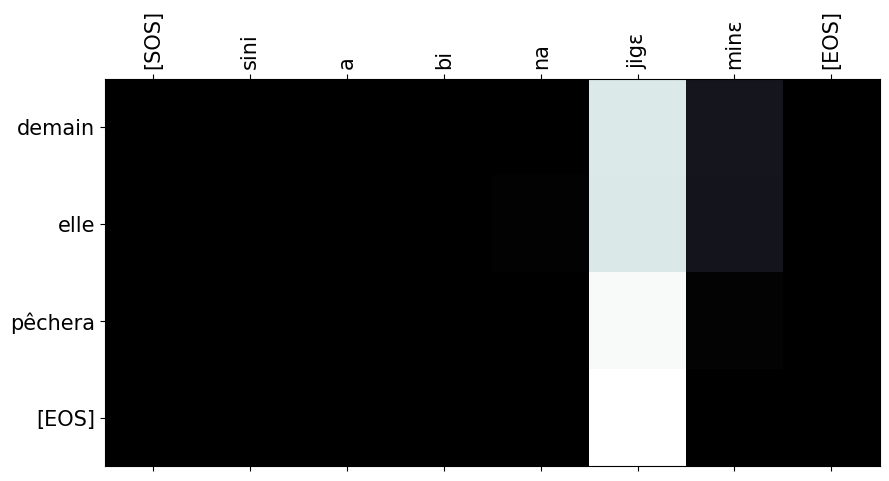

In [131]:
plot_attention(sentence, translation, attn)

In [ ]:
knp;nkn

## Overall Eval

In [ ]:
translations = [
    translate_sentence(
        example["de"],
        model,
        source_vocab,
        target_vocab
    )[0]
    for example in tqdm.tqdm(test_dataloader)
]

In [ ]:
bleu = evaluate.load("bleu")

In [ ]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

In [ ]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [ ]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [ ]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [ ]:
results